## Import libraries


In [13]:
# Import necessary libraries
import numpy as np
import pandas as pd
import pickle as pkl
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import langid
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Input
from keras.callbacks import EarlyStopping

## Loading Dataset

In [2]:
feature_questions, target_intents = pkl.load(open("dataset.pkl", "rb"))

In [3]:
# Convert DataFrames to NumPy arrays if necessary
feature_questions = feature_questions.to_numpy()
target_intents = target_intents.to_numpy()

In [4]:
# Encode target labels if they are in string format
label_encoder = LabelEncoder()
target_intents_encoded = label_encoder.fit_transform(target_intents)


c:\Users\davan\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Model

### slite data

In [5]:
# # Split the data into training and validation sets
X_temp, X_test, y_temp, y_test = train_test_split(feature_questions, target_intents_encoded.ravel(), test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp.ravel(), test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2


In [6]:
# Reshape the data to 3D for LSTM input (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

### LSTM model

In [10]:
# Define the LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(Input(shape=(1, X_train.shape[2])))
    model.add(LSTM(128, return_sequences=False))
    #model.add(LSTM(64, input_shape=(1, X_train.shape[2]), return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(target_intents_encoded)), activation='softmax'))
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [11]:
# Create the model instance
model_lstm = create_lstm_model()

In [14]:
# Set up EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)


In [15]:
# Train the model
history = model_lstm.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.1678 - loss: 2.0873 - val_accuracy: 0.6897 - val_loss: 1.9800
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4797 - loss: 1.9180 - val_accuracy: 0.6552 - val_loss: 1.8138
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5061 - loss: 1.7688 - val_accuracy: 0.6207 - val_loss: 1.5871
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6477 - loss: 1.5022 - val_accuracy: 0.6552 - val_loss: 1.3304
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7067 - loss: 1.2278 - val_accuracy: 0.7586 - val_loss: 1.0600
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6333 - loss: 1.0856 - val_accuracy: 0.8621 - val_loss: 0.8232
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7084 - loss: 0.8806 - val_accuracy: 0.7586 - val_loss: 0.6978
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7524 - loss: 0.9877 - val_accuracy: 0.8621

### Evaluation

In [16]:
# Evaluate on the test set
test_loss, test_accuracy = model_lstm.evaluate(X_test, y_test)


# Predict on the test set
y_test_pred = np.argmax(model_lstm.predict(X_test), axis=1)

# Calculate precision, recall, and f1-score on the test set
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9310 - loss: 0.2114
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Test Loss: 0.2114286720752716
Test Accuracy: 0.931034505367279
Test Precision: 0.9655172413793104
Test Recall: 0.9310344827586207
Test F1 Score: 0.9356321839080459


### Save the model using pickle

In [ ]:
# save the model to disk
model_lstm.save('model_lstm.keras')

In [ ]:
# Save the model using pickle
with open('lstm_model_testing.pt', 'wb') as file: pickle.dump(model_lstm, file)

### Plot

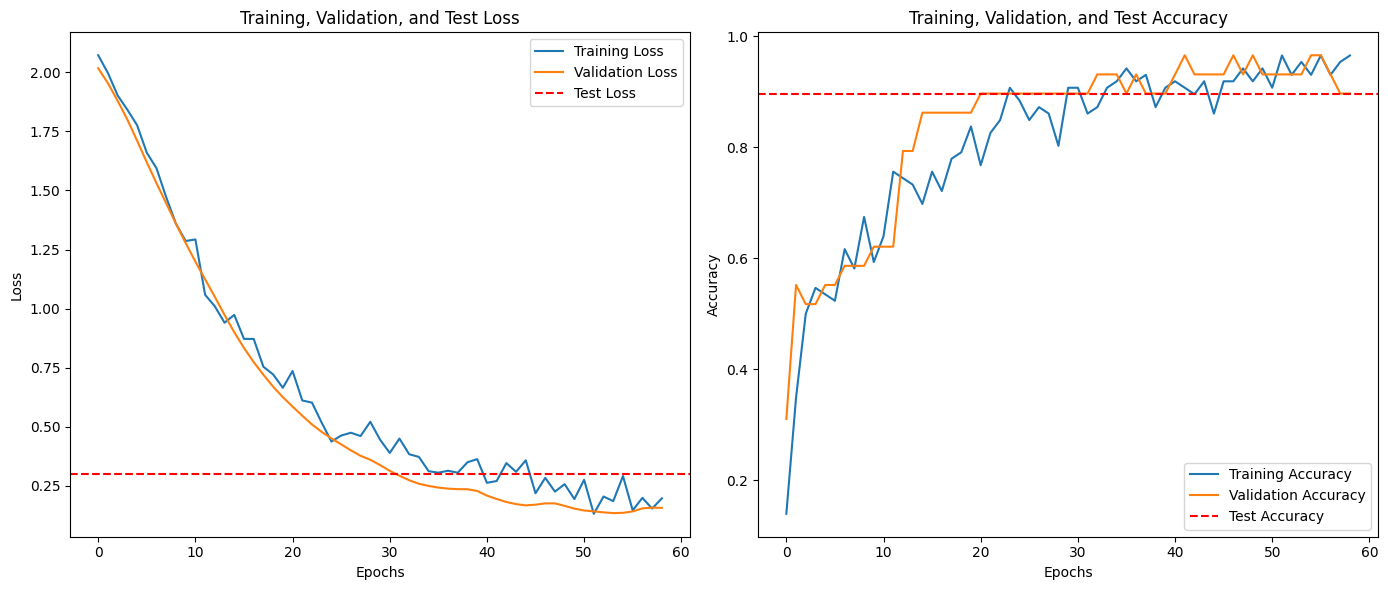

In [13]:
# Plot training, validation, and test loss and accuracy
plt.figure(figsize=(14, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training, Validation, and Test Loss')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training, Validation, and Test Accuracy')

plt.tight_layout()
plt.show()


## Response

In [14]:
class Prediction:
    _instance = None
    def __new__(cls, *args, **kwargs):
        if not cls._instance:
            cls._instance = super().__new__(cls, *args, **kwargs)
        return cls._instance
    
    def __init__(self):
        self.transformer_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
        self.dict_intent_entity = pkl.load(open("dict_intent_entity.pkl", "rb"))  # Update the path as needed
    
    def identify_entity(self, question, list_entities):
        _question = question.lower()
        for entities in list_entities:
            for entity in entities:
                if entity in _question:
                    return entities
        return None

    def identify_language(self, question):
        return langid.classify(question)[0]
    
    def get_answer(self, model, question,label_encoder):
        # Encode the question
        encoded_question = self.transformer_model.encode([question])
        # Reshape to (samples, timesteps, features) for LSTM
        encoded_question = np.array(encoded_question).reshape((1, 1, -1))
        # Predict the intent
        _intent = model.predict(encoded_question)
        _intent = np.argmax(_intent, axis=1)[0]  # Get the index of the highest probability
        # Get the corresponding entities
        _dict_entities = self.dict_intent_entity.get(label_encoder.inverse_transform([_intent])[0], {})
        _list_entities = list(_dict_entities.keys())
        # Identify the entity and get the answer
        _identity = self.identify_entity(question, _list_entities)
        if _identity:
            _answer = _dict_entities[_identity].get(self.identify_language(question), "Answer not available in this language.")
            return _answer
        
        return "I'm sorry, I don't have the ability to answer this question yet."

In [15]:
# Create an instance of Prediction
prediction = Prediction()
# Test with an input question
input_question = "What document do I need to register?"  # Example in Khmer language
answer = prediction.get_answer(model_lstm, input_question,label_encoder)
print(f"Answer: {answer}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Answer: ['The document that school need is _student photo 4x6 _nation ID card _Certificate grade 12. For more infomation https://www.cadt.edu.kh/academic/admission/']
